In [1]:
from Distillation_disc_cont import Simulator
from memory import Memory
from Actor_Critic_lstm import Agent
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
import dill

Using TensorFlow backend.


In [2]:
#dill.load_session('Agent.db')

In [3]:
%autoreload

## Make agent and define hyperparameters

In [4]:
alpha = 1e-6 
beta = 1e-7 
gamma = 0.97

num_episodes = int(1e4)
memory_size = int(1e5)
batch_size = 50
pretrain_eps = batch_size

In [5]:
env = Simulator()
memory = Memory(max_size = memory_size)
agent = Agent(env = env, alpha = alpha, beta = beta, gamma = gamma, layer_size = 30)
agent.actor.summary()
#agent.critic.summary()
#agent.policy.summary()

W0930 21:59:17.143475 10412 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 21:59:17.164547 10412 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0930 21:59:17.167410 10412 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

D:\Github\RL-Process-Design\Discrete and Continuous\Actor_Critic_lstm.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  actor = Model(input = [input, delta], output = [policy_discrete_probs, polic

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 6)            0                                            
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 30)           210         Input[0][0]                      
__________________________________________________________________________________________________
fc2 (Dense)                     (None, 30)           930         fc1[0][0]                        
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 30, 1)        0           fc2[0][0]                        
____________________________________________________________________________________________

## Fill the experience memory

In [6]:
state = env.reset()

for ep in range(pretrain_eps):
    action = env.discrete_action_space.sample(), env.continuous_action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(env.observation_space.shape)
        memory.add((state, action, reward, next_state))
        
    else:
        memory.add((state, action, reward, next_state))
        state = next_state
    

D:\Github\RL-Process-Design\Discrete and Continuous\Distillation_disc_cont.py:65: RuntimeWarning: invalid value encountered in double_scalars
  LK_B = bots[Light_Key]/sum(bots)


In [7]:
score_history = []
for i in range(num_episodes):
    
    done = False
    
    state = env.reset()
    score = 0
    
    while not done:
        action = agent.choose_action_epsgreedy(state, i, num_episodes)
        next_state, reward, done, info = env.step(action)
        #agent.learn(state,  action, reward, next_state, done)
        score += reward
        memory.add((state, action, reward, next_state))
        state = next_state
    
    score_history.append(score)
    next_state = np.zeros(state.shape)
    memory.add((state, action, reward, next_state))
    
    avg_score = np.mean(score_history[-100:]) #average of last 100 scores
    if i%100 == 0:
        print(f'episode {i}, avg_score {avg_score}, last action {action}')
        
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    rewards = np.array([each[2] for each in batch])
    next_states = np.array([each[3] for each in batch])
    
    agent.learn(states,  actions, rewards, next_states, done, batch_size)    


W0930 21:59:19.564894 10412 deprecation_wrapper.py:119] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\keras\backend\tensorflow_backend.py:3005: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

D:\Github\RL-Process-Design\Discrete and Continuous\Distillation_disc_cont.py:75: RuntimeWarning: invalid value encountered in log
  N =  np.log(LK_D/(1-LK_D) * (1-LK_B)/LK_B)/np.log(self.relative_volatility[Light_Key])
D:\Github\RL-Process-Design\Discrete and Continuous\Distillation_disc_cont.py:64: RuntimeWarning: invalid value encountered in double_scalars
  LK_D = tops[Light_Key]/sum(tops)


episode 0, avg_score -1664.9077713146185, last action (0, array([[0.91769196]]))


W0930 21:59:20.880372 10412 deprecation.py:323] From C:\Users\meatrobot\Anaconda3\envs\RL\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
D:\Github\RL-Process-Design\Discrete and Continuous\Distillation_disc_cont.py:75: RuntimeWarning: invalid value encountered in log
  N =  np.log(LK_D/(1-LK_D) * (1-LK_B)/LK_B)/np.log(self.relative_volatility[Light_Key])
D:\Github\RL-Process-Design\Discrete and Continuous\Distillation_disc_cont.py:64: RuntimeWarning: invalid value encountered in double_scalars
  LK_D = tops[Light_Key]/sum(tops)
D:\Github\RL-Process-Design\Discrete and Continuous\Distillation_disc_cont.py:65: RuntimeWarning: invalid value encountered in double_scalars
  LK_B = bots[Light_Key]/sum(bots)


episode 100, avg_score -1819.477268479961, last action (0, array([[0.65437931]]))
episode 200, avg_score -1753.5410905193653, last action (0, array([[0.999]], dtype=float32))
episode 300, avg_score -1746.6119029297072, last action (0, array([[-0.55733516]]))
episode 400, avg_score -1740.8331875561446, last action (0, array([[0.999]], dtype=float32))
episode 500, avg_score -1699.5519941734085, last action (1, array([[0.999]], dtype=float32))
episode 600, avg_score -1732.1858619233687, last action (0, array([[0.88088528]]))
episode 700, avg_score -1685.740570604947, last action (0, array([[0.03031091]]))
episode 800, avg_score -1659.314661936481, last action (0, array([[0.999]], dtype=float32))
episode 900, avg_score -1667.7614144015033, last action (0, array([[0.4903652]]))
episode 1000, avg_score -1695.1806602298498, last action (0, array([[0.58072377]]))
episode 1100, avg_score -1680.6595871322459, last action (0, array([[0.999]], dtype=float32))
episode 1200, avg_score -1629.34324224

episode 9700, avg_score -1513.0914071029215, last action (0, array([[0.76262856]]))
episode 9800, avg_score -1562.9792759651245, last action (3, array([[0.73803971]]))
episode 9900, avg_score -1528.3180617816906, last action (1, array([[0.7444045]]))


In [8]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

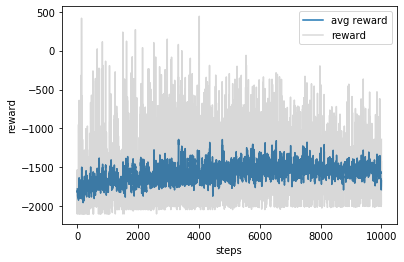

In [9]:
episodes = np.arange(num_episodes)
smoothed_rews = running_mean(score_history, 10)
plt.plot(episodes[-len(smoothed_rews):], smoothed_rews)
plt.plot(episodes, score_history,color='grey', alpha=0.3)
plt.xlabel("steps")
plt.ylabel("reward")
plt.legend(["avg reward", "reward"])

In [10]:
#test agent
state = env.reset()
done = False
while not done:
    state = state[np.newaxis, :]
    action_discrete, action_continuous = agent.policy.predict(state)
    action_discrete = np.argmax(action_discrete)
    action = action_discrete, action_continuous
    
    state, reward, done, info = env.step(action)
    print(f'action LK: {action_discrete}, action split: {action_continuous[0]}, reward: {reward}')

action LK: 1, action split: [0.74847716], reward: -10.758453998299515
action LK: 1, action split: [0.7509184], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0, action split: [0.7535044], reward: -100
action LK: 0

In [ ]:
env.stream_table

In [ ]:
action_discrete, action_continuous = agent.policy.predict(state[np.newaxis, :])

In [ ]:
#dill.dump_session('Agent.db')